## 2. Sensors / Signal Acquisition

Scenario: Multiple experts have been asked, how they would choose the parameters / what they believe are the ranges of the parameters:

#### Placement of Sensors
- $n_\mathrm{sen} = $ Number of sensors max. 12 channels
- $\operatorname{loc}_\mathrm{sen} = 0.2:[\mathrm{lumped}];0.8:[\mathrm{distributed}]$ Placement of sensors (evenly distributed, every five meters, distance between sensors min. 20 meters; both directions simultaneously!)

#### Type of Sensors
- ($q_\mathrm{sen} = 0.8[\mathrm{a}];0.2[\mathrm{v}]$ Measurement quantity (acceleration, velocity))
- $N_0[0.1,1,10,100] = $ Sensor spectral noise
- $\operatorname{DTC} [s] = $ Discharge Time Constant of the sensor

- The epistemic uncertainty due to sensors is, whether suitable sensors have been chosen
- suitability is due to 
    - the sensor frf fitting the bandwitdth of structural vibrations to be measured
    - the sensor noise profile being low enough to not cover structural vibration
- How to model the uncertainty in this step of the process?
    - Inexperienced users just choose any sensor they have
    - Experienced users are able to estimate vibration levels and frequency bands of interest beforehand
    - basically we have 25 discrete choices
    - cluster them in three groups with masses: suitable:0.3, maybe suitable:0.5, not suitable:0.2 (order groups, so we can optimize over integer ranges)
    - put another way, experts would classify each sensor, as suitable or not, then we can use dempster's rule to combine available evidence -> so we assign mass to our experts and transfer it to sensors. now, how do we proceed from here in out measurement process simulation uq?
    - this is somehow inverse to the usual proceeding
    - 
    

#### Signal acquisition system
- Broadband Resolution
    - $q = $ Quantization range. <br>
    **TODO: Usually set on the basis of preliminary measurements. Provide an example signal to given knowledge, and then range x 2 ... 10 and round to a voltage level**
    - $b = [0.05:12, 0.5:16, 0.3:24, 0.05:32]$ Number of quantization bits (**TODO: allow discrete ranges? e.g. 12,16,24,32)**
- Aliasing Filter (FIR: Windowed Sinc)
    - $f_c = $ Filter 3 dB cutoff frequency 2...2.5
    - $w_\mathrm{type}[m]$ Window type  **TODO: Which window types to include (rectangular, hanning, hamming, etc.)?**
    - $M = $ Window length
- $f_s = $ Sample rate $f_s = \frac{1}{\Delta t}$
- $N = $ Number of Timesteps / Measurement Duration $T = N \Delta t$
- $\operatorname{SNR}_\mathrm{acq} = $ Acquisition system noise variance (post-sampling, white noise) <br>
  **TODO: Where to get reasonable values? from Datasheets**
- **TODO: model the built-in highpass filter**

All hardware parameter (Sensors, quantization bits, aliasing cutoff, daq noise) are not so much uncertainties but rather choices. What is needed are **case studies**: 
- suitable hardware, 
- maybe suitable hardware, 
- non-suitable hardware, 
rather than mixing and hiding everything under the cover of uncertainties. By doing interval optimization of the final output variable over bad and good sensors combined we would get huge intervals, which is expected and has no relation to reality. Here, usually some type of hardware is available and can be rated with regards to suitability and we are interested to know how much it affects the final output uncertainty. 

So, we would still sample hardware in the epistemic space and the optimize over all the samples, whith the right combination of hardware. To make it easier to apply optimizers, hardware should be ordered by suitability and we can optimize over integer ranges, instead of discrete choices. **TODO: check, that integers are supported by optimizers**



#### Outputs
- Total SNR
- Effective quantization bits [Channel average] (Considering range, bits and actual vibration level)
- **TODO: Estimated SNR**

##### Ressources:
https://en.wikipedia.org/wiki/RC_circuit

https://www.pcb.com/resources/technical-information/signal-conditioning-basics#collapse13

https://www.pcbpiezotronics.de/produkte/datenblatt?h=PCB&m=352C33&cHash=1bd70739507f7a96620a16632ca50a2c

/home/womo1998/Downloads/Jon%20S.%20Wilson%20-%20Sensor%20Technology%20Handbook-Newnes%20(2005).pdf

https://www.edn.com/a-guide-to-accelerometer-specifications/

https://www.f3lix-tutorial.com/

https://kistler.cdn.celum.cloud/SAPCommerce_Download_original/900-380e.pdf

https://dewesoft.com/blog/noise-floor-analysis

##### Continue:
- ✔️ Add Kistler Sensors -> Not included due to missing noise specifications from data sheets
    - https://www.kistler.com/DE/en/cp/low-temperature-iepe-accelerometers-8712b/P0000551
    - https://www.kistler.com/DE/en/cp/triaxial-iepe-accelerometers-8762a/P0000558
- ✔️ Inverse FRF model with incomplete Data
- ✔️ Make sensor database available programmatically
- ✔️ Categorize in terms of noise and plot spectral noise curves
- Write Function apply sensor
    - Apply FRF (DTC, fn) (by convolution or in frequency domain, or just the high-pass part as a filter with filtfilt)
    - https://www.eeeguide.com/first-order-high-pass-butterworth-filter-derivation/
    - Add noise (noise profile vector) (in time domain)
    - (Apply DAQ FRF, same as sensor FRF)
    - (Apply DAQ noise (broadband standard deviation, in time domain))
    - -> continue on to sampling function
- Write about:
    - Theory/ Assumptions/  Charge amplified accelerometers, principle (resonance), amplifiers (highpass RC filter, Settling time, discharge time, etc.)
    - Sensitivity (Deviation, Temperature Deviation, Strain Deviation, Linearity)
    - Frequency response (Frequency Ranges)
    - Noise (Resistor, Transistor) Spectral, Broadband, RMS, peak, integration
- Write Save/Load function for Acquire

- Do some research into digitizers?
    - Digitizers with IEPE (and BNC connection):
        - NI, Kistler, Gantner, B&K, ... ?
        - https://dewesoft.com/products/sirius-r2-r4/tech-specs#acc
        - https://dewesoft.com/products/dsi-adapters#dsi-acc
        - https://sinus-leipzig.de/de/produkte/messsysteme/apollo-light-carrier-data-acquisition-hardware-for-sound-and-vibration-analysis
    - The most important properties seem to be:
        - Resolution -> Gather some data 
        - AC coupling (all IEPE system must have it) (-3dB cutoff frequency, -0.1 dB cutoff frequency) -> Gather some data / ranges
        - Analog Input Noise -> Gather some data / ranges
    - Maybe important:
        - Gain Accuracy, 
        - Frequency response: Flatness (0.02dB max), phase linearity, interchannel phase mismatch, -3dB bandwidth
        - Distortion plus Noise, 
    - Others are
        - ADC type, 
        - Sampling mode, 
        - Sample rates (Range, Resolution), 
        - Internal frequency accuracy, 
        - Input range, 
        - Impedance, 
        - Gain Accuracy,
        - CMRR, 
        - Crosstalk,

In [2]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
%load_ext snakeviz
# dont forget to forward ports: ssh -L 8080:127.0.0.1:8080 sima9999@makalu47.rz.tu-ilmenau.de

import sys
import os
sys.path.append("/home/sima9999/code/")
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.signal

from uncertainties import ufloat


from model.mechanical import Mechanical, MechanicalDummy
from model.acquisition import Acquire
from examples.UQ_OMA import plot_response_field

%aimport -sys -logging -matplotlib -matplotlib.pyplot -numpy -pandas - scipy.stats -scipy.stats.qmc

## Parameters

In [3]:
'''
Continue:

estimate incompleteness on any output e.g. RMS_a(TMD_y)


Read, understand and connect model.acquisition.Acquire class with model.mechanical.Mechanical
implement helper to generate channel definitions
implement method apply_sensor
'''
result_dir = Path('/usr/scratch4/sima9999/work/modal_uq/uq_oma_a/')
working_dir = Path('/dev/shm/womo1998/')

## Structural Model generation

INFO:model.mechanical:Now loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_oma_a/samples/mechanical.npz


Text(0, 0.5, 'Modal damping ratio [%]')

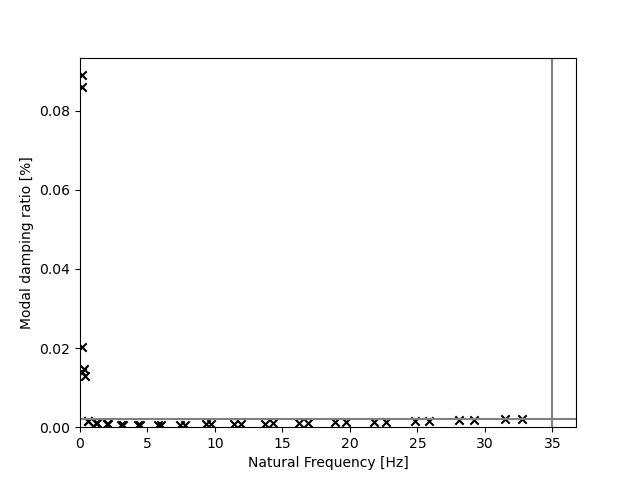

In [4]:
from model.mechanical import Mechanical, MechanicalDummy

if os.path.split(result_dir)[-1] != 'samples':
    result_dir=result_dir / 'samples'

jid = 'd3f294e6_e3f6077f'

zeta = 0.002 # normal damping
# zeta = 0.0005 # light damping
# zeta = 0.005 # heavy damping
Iy = 0.01196
Iz = 0.01304
alpha = 45

fs_m = 70
duration = 2**19/fs_m

v_b = 25.0
skip_existing = True

if not isinstance(result_dir, Path):
    result_dir = Path(result_dir)

if not isinstance(working_dir, Path):
    working_dir = Path(working_dir)

# Set up directories
if '_' in jid:
    id_ale, id_epi = jid.split('_')
    this_result_dir = result_dir / id_ale
    if not os.path.exists(this_result_dir):
        os.makedirs(this_result_dir)

    this_result_dir = this_result_dir / id_epi
    if not os.path.exists(this_result_dir):
        os.makedirs(this_result_dir)
else:
    this_result_dir = result_dir / jid
    if not os.path.exists(this_result_dir):
        os.makedirs(this_result_dir)


seed = int.from_bytes(bytes(jid, 'utf-8'), 'big')
        
# assemble structural parameters
struct_parms = {
        'L'         : 200,

        'E'         : 2.1e11,
        'A'         : 0.03287,

        'x_knl'     : 160,

        'm_tmd'     : 800,
        'ky_tmd'    : 1025.48,
        'kz_tmd'    : 1025.48,
        'dy_tmd'    : 200,
        'dz_tmd'    : 200,
        'x_tmd'     : 200,
        }

# Cross-section
Iyz = 0
# rotate cross section about angle alpha
alpha = alpha * 2 * np.pi / 360
struct_parms['Iy'] = 0.5 * (Iy + Iz) + 0.5 * (Iy - Iz) * np.cos(2 * alpha) + Iyz * np.sin(2 * alpha)
struct_parms['Iz'] = 0.5 * (Iy + Iz) - 0.5 * (Iy - Iz) * np.cos(2 * alpha) - Iyz * np.sin(2 * alpha)
struct_parms['Iyz'] = -0.5 * (Iy - Iz) * np.sin(2 * alpha) + Iyz * np.cos(2 * alpha)

# equivalent spring stiffness of guy cables
A_wire = 0.00075
rho = 7850
N_wire = 60000
Aeq = A_wire/(1 + (A_wire * rho * 9.819 * 70 / N_wire)**2 * struct_parms['E'] * A_wire / 12 / N_wire)
keq = (struct_parms['E'] * Aeq * (70**2 / (70**2 + 160**2)) + N_wire) / np.sqrt(70**2 + 160**2)
struct_parms['kz_nl'] = 1.7 * keq
struct_parms['ky_nl'] = 2 * keq

# additional mass into mass density
add_mass = 60
struct_parms['rho'] = rho + add_mass / struct_parms['A']

# model parameters
num_nodes = 201
num_modes = 38 # ensure max(f) is below nyquist frequency to avoid wrap-around in the frf

# load or build structural model
mech = None
if skip_existing and os.path.exists(result_dir / f'mechanical.npz'):
    try:
        mech = MechanicalDummy.load(fpath=result_dir / f'mechanical.npz')
        assert mech.struct_parms['Iy'] == struct_parms['Iy']
        assert mech.struct_parms['Iz'] == struct_parms['Iz']
        assert mech.struct_parms['Iyz'] == struct_parms['Iyz']
        assert mech.damping == zeta
        assert mech.omegas is not None
        assert mech.frf is not None
    except Exception as e:
        mech = None
        raise e

if mech is None:
    global ansys
    if 'ansys' not in globals():
        ansys = Mechanical.start_ansys(working_dir=working_dir, jid=jid)
    mech = Mechanical(ansys=ansys, jobname=jid, wdir=working_dir)
    mech.build_conti(struct_parms, 
                     Ldiv=num_nodes, damping=zeta, 
                     num_modes=num_modes)

f,d,phi = mech.modal()

plt.figure()
plt.axhline(zeta, color='grey')
plt.axvline(fs_m/2, color='grey')
plt.scatter(f,d,  marker='x', color='k')
plt.xlim(xmin=0)
plt.ylim(ymin=0)
plt.xlabel('Natural Frequency [Hz]')
plt.ylabel('Modal damping ratio [%]')
# plt.yscale('log')

## Transient Solution

In [5]:
%%time
if os.path.exists(this_result_dir / 'response.npz') and skip_existing:
    arr = np.load(this_result_dir / 'response.npz')
    t_vals = arr['t_vals']
    d_freq_time = arr['d_freq_time']
    v_freq_time = arr['v_freq_time']
    a_freq_time = arr['a_freq_time']
else:
    t_vals, response = mech.transient_ifrf(Fu_time, Fv_time,
                                           mech.nodes_coordinates[0:-2,0],
                                           inp_dt = 1 / fs_m)

    [d_freq_time, v_freq_time, a_freq_time] = response       
    # FRF was not pre-computed: save, clear and exit
    if isinstance(mech, Mechanical):
        print('save')
        mech.save(os.path.join(result_dir, 'mechanical.npz'))
        ansys.finish()
        ansys.cwd('/dev/shm/womo1998/')
        ansys.clear()
    
    np.savez(this_result_dir / 'response.npz', 
             t_vals=t_vals, 
             d_freq_time=d_freq_time, 
             v_freq_time=v_freq_time, 
             a_freq_time=a_freq_time)
    print(this_result_dir / 'response.npz')

# zeros = np.zeros((N_m, 1))
# t, [d_time, v_time, a_time] = mech.transient(fy=np.hstack((Fu_time, zeros, zeros)), 
#                                              fz=np.hstack((Fv_time, zeros, zeros)), 
#                                              deltat=1 / fs_m, timesteps=N_m)
# # remove DOF x
# d_time = d_time[:,:,1:]
# v_time = v_time[:,:,1:]
# a_time = a_time[:,:,1:]

CPU times: user 6.05 s, sys: 2.48 s, total: 8.53 s
Wall time: 11.5 s


(<Figure size 640x480 with 3 Axes>,
 <Figure size 640x480 with 3 Axes>,
 <Figure size 640x480 with 3 Axes>)

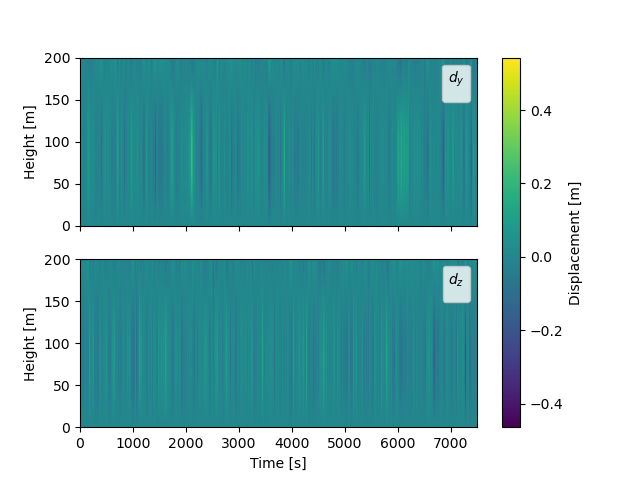

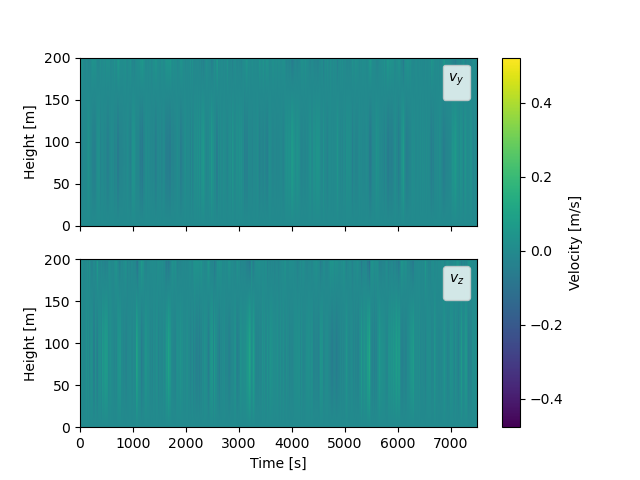

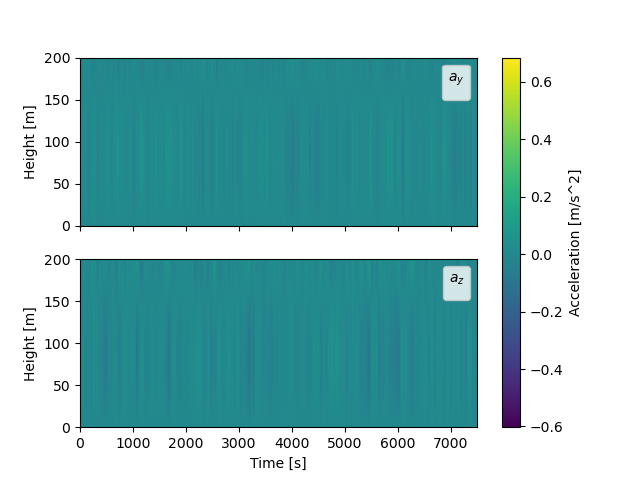

In [6]:
plot_response_field(d_freq_time, v_freq_time, a_freq_time, duration, height=200)

In [7]:
mech.t_vals_amb = t_vals
mech.resp_hist_amb = [d_freq_time, v_freq_time, a_freq_time]
mech.deltat = t_vals[1] - t_vals[0]
mech.timesteps = t_vals.shape[0]
mech.state[2] = True

## Signal Acquisition

### Placement of sensors

Uncertainty is about:
Where will it be possible to place sensors (epistemic, reducible)?
How can the modal characteristics be best captured in a given frequency range?

In reality:
A numerical model is set up based on uncertain model parameters and solved. A 
frequency range of interest is selected. Commonly the the modes up to fifth order
are of interest (sampling is later done at a much higher sample rate, though). 
Then, by assessing the mode shapes, the location of sensors is decided upon.
It won't be possible to place the sensors at arbitrary locations and also some
practical issues, such as cable lengths, etc. come into play. 

Single-setup or multi-setup measurements are possible. In multi-setup
measurements, usually a reference sensor is placed at a location, where all
modes of interest exhibit sufficient vibration levels. The remaining sensors can
then be distributed evenly or lumped in multiple setups until all locations of
interest are covered.
In single-setup measurements, it is tried to place all available sensors such
that all modes of interest exhibit as large vibration levels as possible, i.e.
avoid nodes of mode shapes [brehm2011vibration]. 
This method requires the mode shapes and natural frequencies to be known beforehand
To stay with the notion of the study, these are epistemically uncertain. We would 
have to model this uncertainty, which would deviate too far from the original goals of the study.
Another option would be to just distribute them evenly.

In this example,
we assume, sensors can be placed every five meters and on the TMD itself.
In either case, assume a sensor is placed at the top node. The TMD node may then
be covered by the specified placement method.
divide remaining range, not on bottom node
lumped or evenly distributed
randomly choose one of the possible setups

In [8]:
def sensor_position(num_sensors, num_nodes, method):
    assert method in ['lumped','distributed']

    all_positions = np.arange(5, num_nodes, 5)
    num_positions = all_positions.shape[0]
    num_clusters = int(np.floor(num_positions/num_sensors))

    if method == 'distributed': 
        clusters = np.reshape(all_positions[:num_sensors*(num_clusters)], (num_sensors, num_clusters)).T
        last_setup = all_positions[- (num_sensors - 1) * (num_clusters) - 1::num_clusters]
    elif method == 'lumped': 
        clusters = np.reshape(all_positions[:num_sensors*(num_clusters)], (num_clusters, num_sensors))
        last_setup = np.reshape(all_positions[-num_sensors:], (1, num_sensors))

    clusters = np.vstack((clusters, last_setup))

    return clusters

In [9]:
# list of (node, dof, quant)
n_channels = 14
quant = 'a'
i_cluster=1

sensor_nodes = sensor_position(n_channels//2, mech.num_nodes, 'distributed')[i_cluster,:]
channel_defs = []
for node in sensor_nodes:
    for dof in ['ux','uy']:
        channel_defs.append((node, dof, quant))


In [10]:
#TODO: Generate Channel Defs from sensor_position and then continue implementation

acqui = Acquire.init_from_mech(mech, channel_defs)

INFO:model.acquisition:Initializing Acquire object from a Mechanical object


### Sensor Database

A list of currently available analog seismic accelerometers was compiled. Those are assumed suitable for ambient vibration testing on civil structures with the purpose of conducting Operational Modal Analysis. Other sensors, such as Digital/MEMS accelerometers, accelerometers with a sensitivity below 0.1V/g, seismometers (measuring velocities), laser vibrometers etc. are made for different purposes and are not included here. Temperature is assumed constant at specification temperature, no temperature transients, sensitivity deviations, etc. are considered. Assuming proper mounting, thus no changes to sensitivity due to base strain. Assuming properly calibrated sensors, with known sensitivities, (no sensitivity deviations).

The characteristics of the sensors are specified differently by the manufacturers: 
- in g or m/sec^2, 
- in different frequency bands
- in decibel or percent



In [11]:
sensor_data = pd.read_csv('/home/sima9999/2019_OMA_UQ/data/sensor_data.csv', header=[0,1])


In [12]:
N=2**16
for sensor, row in sensor_data.iterrows():

    noise_profile = row[19:26].array.astype(float)
    if np.all(np.isnan(noise_profile)): continue
    spectral_freq = np.array([0.1,1,2,10,100,1000,10000])[~np.isnan(noise_profile)]
    noise_profile = noise_profile[~np.isnan(noise_profile)]
    freq = np.linspace(noise_profile.min(), noise_profile.max(),N//2+1)
    delta_f = freq[1]-freq[0]
    dt=1/delta_f/N
    phase = np.random.uniform (-np.pi, np.pi, N//2+1)
    psd = np.interp(freq, spectral_freq, noise_profile) * np.exp(1j * phase)
    # Convert spectral density [(µm/sec2)/√Hz] to spectrum [(µm/sec2)/Hz]
    psd /= np.sqrt(dt)
    integr_noise = np.sqrt(np.sum(np.abs(psd)**2) / N * 2)
    sensor_data.loc[sensor,'Total Noise'] = integr_noise

In [13]:
pd.set_option('display.max_columns', None)
display(sensor_data)

Manufacturer              Model  Sensitivity Measurement Range ±  \
                Unit Unnamed: 1_level_1 mV/(m/sec^2)             m/sec^2   
0                B&K         4507-B-004         9.99                 NaN   
1                B&K         4507-B-005        99.90                 NaN   
2                B&K         4507-B-006        49.95                 NaN   
3                B&K               8344       249.75               26.00   
4                B&K         8344-B-001        49.95              137.00   
5                B&K         8344-B-002       499.49               14.00   
6    DJB Instruments         A/1600/V/1       101.94                 NaN   
7    DJB Instruments         A/1600/V/5       509.68                 NaN   
8    DJB Instruments           A/1800/V      1019.37                4.90   
9            ENDEVCO         Model 87/1       101.94               49.05   
10           ENDEVCO        Model 87/10      1019.37             4905.00   
11            Metrix             SA6200        10.19              490.50   
12               MMF             KB12VD      1019.37             5886.00   
13               MMF              KS48C       101.94               58.86   
14               MMF             KS823B        50.97              117.72   
15  PCB PIEZOTRONICS             393A03       102.00               49.00   
16  PCB PIEZOTRONICS             393B04       102.00               49.00   
17  PCB PIEZOTRONICS             393B05      1020.00                4.90   
18  PCB PIEZOTRONICS             393B12      1019.40                4.90   
19  PCB PIEZOTRONICS             393B31      1020.00                4.90   
20  PCB PIEZOTRONICS             393B32       510.00                9.80   
21  PCB PIEZOTRONICS               393C       101.90               24.50   
22          Wilcoxon            731-207      1019.37             4905.00   
23          Wilcoxon               731A      1019.37             4905.00   
24          Wilcoxon               735T      1019.37             4905.00   
25          Wilcoxon               799M       101.94               49.05   

         Max Sinusoidal Acceleration (peak) / Destruction Limit  \
      mV                                                m/sec^2   
0    NaN                                             700.00       
1    NaN                                              70.00       
2    NaN                                             140.00       
3   6.49                                              19.62       
4   6.84                                              98.10       
5   6.99                                               9.81       
6    NaN                                                NaN       
7    NaN                                                NaN       
8   4.99                                                NaN       
9   5.00                                             490.50       
10  5.00                                             490.50       
11  5.00                                                NaN       
12  6.00                                            1962.00       
13  6.00                                            9810.00       
14  6.00                                           19620.00       
15  5.00                                                NaN       
16  5.00                                                NaN       
17  5.00                                                NaN       
18  5.00                                                NaN       
19  5.00                                                NaN       
20  5.00                                                NaN       
21  2.50                                                NaN       
22  5.00                                             490.50       
23  5.00                                              98.10       
24  5.00                                              98.10       
25  5.00                                            2452.50       

  

#### Derivation of the time constant

The Discharge Time Constant (DTC) is a property of the piezoelectric element and the amplifier electronics. It is dependend on the capacity $C_p$ and internal resistance $R_p$ (typically with an resistance $R_p > 10^{12} ... 10^{14} \Omega$ of the PE element. In parallel, the amplifier includes a capacitor $C_r$ (to control the gain of the sensor, charge accumulates slower and therefore higher currents (=forces) are possible) and a resistor $R_r$ to make sure $C_r$ does not become saturated. Together, these form the DTC $T=(R_r+R_p)(C_r+C_p)$. This parallel RC circuit acts as a high-pass filter due to being fed by a current source (https://en.wikipedia.org/wiki/RC_circuit#Parallel_circuit). It should be noted, that these characteristics depend on environmental factors such as temperature and humidity and make it difficult to specify certain values.

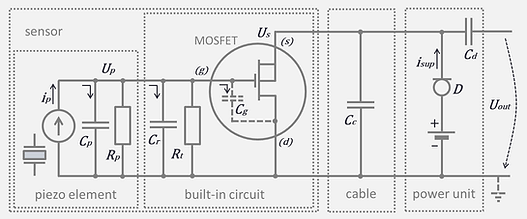

(source: https://www.f3lix-tutorial.com/signal-electronics)

In the time domain it causes any charges in the PE element to discharge over time. The discharge curve is defined as
$$
q(t) = Q e^\frac{-t}{T} \, \text{,}
$$
where $Q$ is the initial charge. It means that after a time $T$ the charge has decreased to $36.8 \%$ of $Q$ and reduce to $10 \%$ after $2.3 T$. The effect on the step response is depicted below:

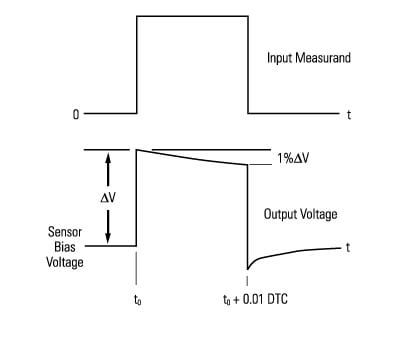

(source:https://www.pcb.com/resources/technical-information/signal-conditioning-basics#collapse13)

In the frequency domain, it acts as a high-pass filter with transfer function 
$$H_{RC}=\frac{RCj\omega}{1+RCj\omega}$$

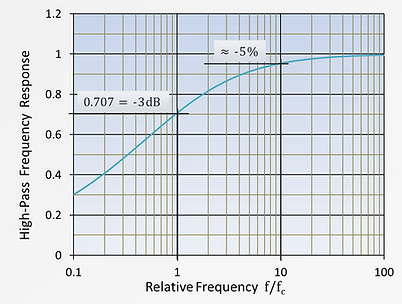

(source: https://www.f3lix-tutorial.com/signal-electronics)


''When looking at very low frequencies another detail might be important: The decoupling capacitor Cd together with the input resistance of the follow-on instrument will form yet another RC time constant, this time a high-pass filter. With typically 10 μF for Cd  we need a minimum 1 Megohm input impedance on the follow-on equipment to obtain a time constant of 10 seconds. This also assumes a MOSFET output impedance of <100 Ω. As a general rule, the coupling time constant should be at least 10 times larger than the sensor time constant.''
(source: https://www.f3lix-tutorial.com/signal-electronics)

In the datasheets, several values relate to the DTC:
- The settling time / warm up time / start-up time, which may however be affected by other characteristics of the operational amplifier. Typically, it is specified where the bias voltage is within $10 \%$ of its stabilized value, therefore DTC follows by division with $2.5$ (see above)

''settling time includes the effects of the temperature and power coefficients in precision resistors, as well as other components, such as precision voltage references, analog to digital converters, digital to analog converters, etc. Other effects also factor into the equipment warm-up time, such as the same power and temperature coefficients of the power supply for the equipment, the charging time constant of filter or bias circuits (more prevalent in transducers)'' (source: https://www.modalshop.com/calibration/learn/accelerometers/equipment-warm-up-thermal-stability)
- The $5\%$, $10\%$ and $-3dB$ marks of the lower frequency response magnitude. $RC$ the follows as 
$$RC = \frac{H}{\omega\sqrt{1-H^2}}$$, 
where $H_{5\%} = 0.95$, $H_{10\%} =0.9$ and $H_{-3dB} =0.0.708$, respectively and $\omega = 2 \pi f_{5\%,10\%,-3dB}$
    

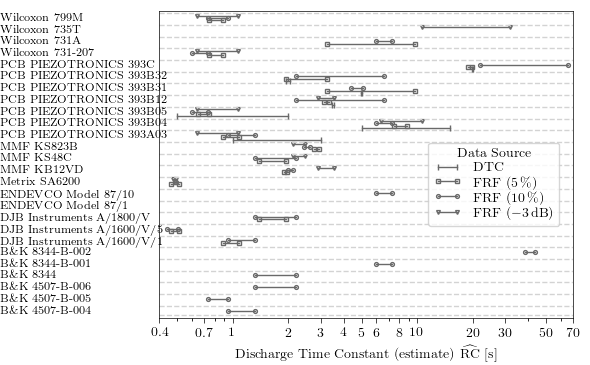

In [14]:
def to_interv(val):
    if isinstance(val, str) and 'to' in val:
        return [float(num) for num in val.split('to')]
    elif not isinstance(val, str) and np.isnan(val):
        return val, val
    elif isinstance(val, str):
        val = float(val)
    int_, dec_ = repr(val).split('.')
    sig_dig = len(dec_) + 1
    unc = (5 / 10**sig_dig)
    return val - unc, val + unc

import re

def tex_escape(text):
    """
        :param text: a plain text message
        :return: the message escaped to appear correctly in LaTeX
    """
    conv = {
        '&': r'\&',
        '%': r'\%',
        '$': r'\$',
        '#': r'\#',
        '_': r'\_',
        '{': r'\{',
        '}': r'\}',
        '~': r'\textasciitilde{}',
        '^': r'\^{}',
        '\\': r'\textbackslash{}',
        '<': r'\textless{}',
        '>': r'\textgreater{}',
    }
    regex = re.compile('|'.join(re.escape(str(key)) for key in sorted(conv.keys(), key = lambda item: - len(item))))
    return regex.sub(lambda match: conv[match.group()], text)


matplotlib.rc('text.latex', preamble=r"\usepackage{siunitx}\usepackage{xfrac}")
plt.close('all')
from helpers import get_pcd
with matplotlib.rc_context(get_pcd('print')):  
    plt.figure()
    line = 0
    plt.axhline(line, c='lightgrey', ls='dashed', lw=1)
    for sensor, row in sensor_data.iterrows():
        line_start = line + 0
        # print(row['Manufacturer'].item()+' '+row['Model'].item())
        # st_l, st_h = to_interv(row[10])
        # if not np.isnan(st_l) and not np.isnan(st_h): 
        #     DTC_l = st_l/2.5
        #     DTC_h = st_h/2.5
        #     # print(f'From settling time: [{DTC_l:1.3f}, {DTC_h:1.3f}]')
        #     plt.plot([DTC_l, DTC_h],[line,line], marker='o', markersize=2.75, color='yellow')
        # line += 1
        DTC_l, DTC_h = to_interv(row[11])
        if not np.isnan(DTC_l) and not np.isnan(DTC_h): 
            # print(f'From datasheet: [{DTC_l:1.3f}, {DTC_h:1.3f}]')
            plt.plot([DTC_l, DTC_h],[line,line], marker='|', markersize=4, color='dimgrey', lw=1)
        line += 1
        f5_l, f5_h = to_interv(row[12])
        if not np.isnan(f5_l) and not np.isnan(f5_h):
            H5 = 0.95
            DTC_l = H5 / (2 * np.pi * f5_l * np.sqrt(1 - H5**2))
            DTC_h = H5 / (2 * np.pi * f5_h * np.sqrt(1 - H5**2))
            # print(f'From 5 % FRF point: [{DTC_l:1.3f}, {DTC_h:1.3f}]')
            plt.plot([DTC_l, DTC_h],[line,line], marker='s', fillstyle='none', markersize=2.75, color='dimgrey', lw=1)
            
            sensor_data.loc[sensor,'DTC5_l'] = DTC_l
            sensor_data.loc[sensor,'DTC5_h'] = DTC_h
        line += 1
        f10_l, f10_h = to_interv(row[14])
        if not np.isnan(f10_l) and not np.isnan(f10_h): 
            H10 = 0.90
            # print(row[14], f10_l, f10_h)
            DTC_l = H10 / (2 * np.pi * f10_l * np.sqrt(1 - H10**2))
            DTC_h = H10 / (2 * np.pi * f10_h * np.sqrt(1 - H10**2))
            # print(f'From 10 % FRF point: [{DTC_l:1.3f}, {DTC_h:1.3f}]')
            plt.plot([DTC_l, DTC_h],[line,line], marker='o', fillstyle='none', markersize=2.75, color='dimgrey', lw=1)
            
            sensor_data.loc[sensor,'DTC10_l'] = DTC_l
            sensor_data.loc[sensor,'DTC10_h'] = DTC_h
        line += 1
        f30_l, f30_h = to_interv(row[16])
        if not np.isnan(f30_l) and not np.isnan(f30_h):
            H30 = 10**-0.15
            DTC_l = H30 / (2 * np.pi * f30_l * np.sqrt(1 - H30**2))
            DTC_h = H30 / (2 * np.pi * f30_h * np.sqrt(1 - H30**2))
            # print(f'From -3dB FRF point: [{DTC_l:1.3f}, {DTC_h:1.3f}]')
            plt.plot([DTC_l, DTC_h],[line,line], marker='v', fillstyle='none', markersize=2.75, color='dimgrey', lw=1)
            
            sensor_data.loc[sensor,'DTC30_l'] = DTC_l
            sensor_data.loc[sensor,'DTC30_h'] = DTC_h
        line += 1
        label = row['Manufacturer'].item()+' '+row['Model'].item()
        label = tex_escape(label)
        plt.annotate(label, (0,(line + line_start)/2),xycoords=('figure fraction','data'), va='center_baseline', ha='left', size='small')
        plt.axhline(line, c='lightgrey', ls='dashed', lw=1)
        line += 1

    from matplotlib.lines import Line2D    
    custom_lines = [Line2D([0], [0], color='dimgrey', label='DTC', marker='|', markersize=4, lw=1),
                    Line2D([0], [0], color='dimgrey', label='FRF (\SI{5}{\percent})',  marker='s', fillstyle='none', markersize=2.75, lw=1),
                    Line2D([0], [0], color='dimgrey', label='FRF (\SI{10}{\percent})', marker='o', fillstyle='none', markersize=2.75, lw=1),
                    Line2D([0], [0], color='dimgrey', label='FRF (\SI{-3}{\decibel})',  marker='v', fillstyle='none', markersize=2.75, lw=1)]
    
    plt.subplots_adjust(left=0.27,right=0.97, top=0.97, bottom=0.13)
    plt.xlim((0,66))
    plt.ylim((-1,line))
    plt.legend(title='Data Source', handles=custom_lines, loc=(0.65,0.3), numpoints=2)
    plt.yticks([])
    plt.xlim((0.4,70))
    plt.xscale('log')
    formatter= plt.ScalarFormatter()
    plt.gca().get_xaxis().set_major_formatter(formatter)
    # plt.gca().get_xaxis().set_minor_formatter(formatter)
    ticks = [0.4,0.7, 1,2,3,4,5,6,8,10,20,30,50,70]
    plt.gca().set_xticks(ticks, [repr(val) for val in ticks])
    plt.xlabel(' Discharge Time Constant (estimate) $\widehat{\mathrm{RC}}$ [\si{\second}]') 
    plt.show()

#### IIR Filter Design (Highpass due to Discharge Time Constant)

The frequency response of the sensor is to be represented by a first-order Butterworth filter, taking the sensitivity into account.

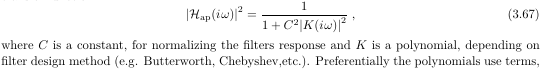

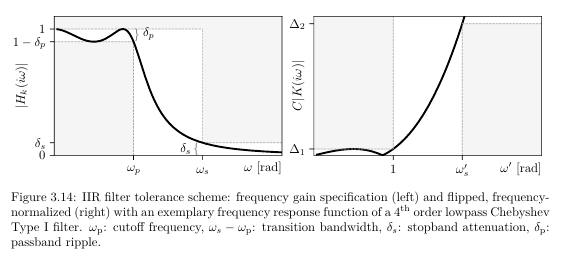

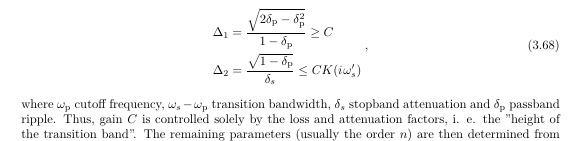

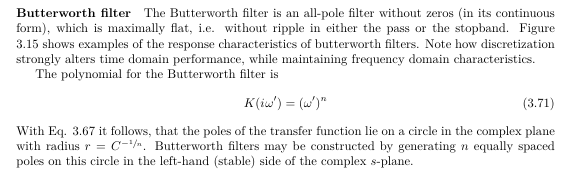

The cutoff frequency of an RC-Circuit is 
$$ f_c = \frac{1}{2 \pi RC}$$
it must be normalized to the signals Nyquist frequency as 
$$ \overline{f}_c = \frac{2 f_c}{f_s}$$
With $\overline{f}_c$ we can build a first-order butterworth filter and apply it width scipy.signal.lfilter

### Spectral Sensitivity

The spectral sensitivity consist of three parts:
- The high frequency response, determined by the resonant frequency of the sensor -> given as an inequality
- The low frequency response, due by the high-pass filtering of the internal electronics (RC-Circuit), determined by the Discharge Time Constant
- The sensivitity of the sensor, i.e. the voltage to acceleration relation -> given as a range or inequality


The resulting 2-DOF FRF is additionally specified in terms of the frequency ranges for a sensitivity deviation of $\pm$ 5 % and $\pm10$ %, respectively. The theoretical and tabulated FRFs match only approximately.

In [60]:
fn = 50000
frequencies = np.fft.rfftfreq(acqui.num_timesteps, acqui.deltat)
zeta_sensor=0.01
ind = np.argmin(np.abs((frequencies - 5000)))
display(frequencies[ind])

time_constant = 1.1# Entladezeitkonstante 1...2.5 s = R*C
fc=1/2/np.pi/time_constant
display(fc)

35.0

0.14468631190172304

In [61]:
D1 = 1 + 2 * 1j * zeta_sensor * frequencies / fn
D2 = 1 - (frequencies / fn)**2 + 2 * 1j * zeta_sensor * frequencies / fn
Hf = D1 / D2
Hc = time_constant * 2 * np.pi * 1j * frequencies / (1 + time_constant * 2 * np.pi * 1j * frequencies)
H = Hf * Hc

/tmp/ipykernel_16980/2369155960.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.plot(frequencies, 20*np.log10(np.abs(H)))


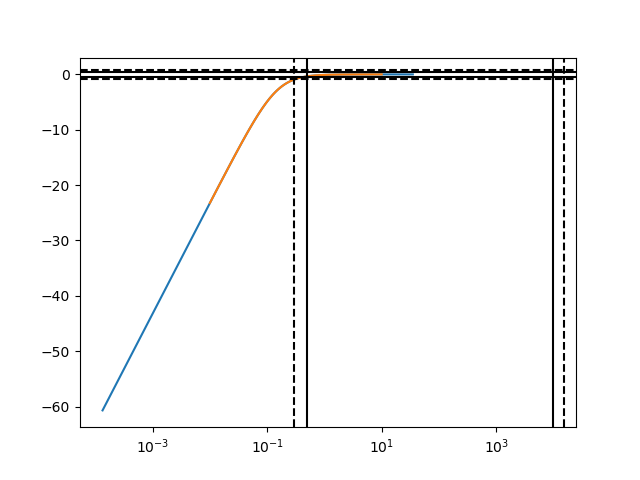

In [68]:
plt.figure()
plt.plot(frequencies, 20*np.log10(np.abs(H)))
b, a = signal.butter(1, fc, 'high', analog=True)
w, h = signal.freqs(b, a)
plt.semilogx(w, 20 * np.log10(abs(h)))
plt.axvline(0.5,color='k',)
plt.axvline(10000,color='k',)
plt.axhline(20*np.log10(1.05),color='k',)
plt.axhline(20*np.log10(0.95),color='k',)
plt.axvline(0.3, color='k',ls='dashed')
plt.axvline(15000, color='k',ls='dashed')
plt.axhline(20*np.log10(1.1), color='k',ls='dashed')
plt.axhline(20*np.log10(0.9), color='k',ls='dashed')
plt.xscale('log')

/tmp/ipykernel_16980/427402449.py:31: RuntimeWarning: divide by zero encountered in log10
  collection = ax.fill_between(frequencies, 20*np.log10(np.abs(H_l)),20*np.log10(np.abs(H_h)), alpha=0.5, ls='solid', color='dimgrey')
/tmp/ipykernel_16980/427402449.py:32: RuntimeWarning: divide by zero encountered in log10
  ax.plot(frequencies, 20*np.log10(np.abs(H_l)), color='dimgrey', ls=linestyle)
/tmp/ipykernel_16980/427402449.py:33: RuntimeWarning: divide by zero encountered in log10
  ax.plot(frequencies, 20*np.log10(np.abs(H_h)), color='dimgrey', ls=linestyle)


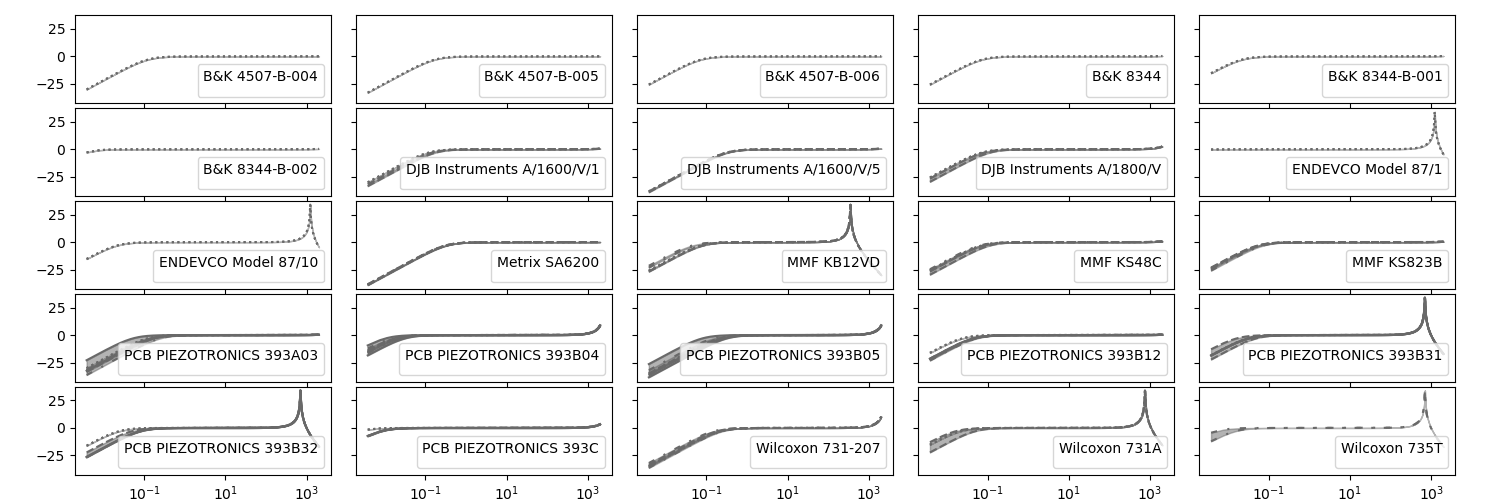

In [15]:
fig, axes = plt.subplots(5,5, sharex=True, sharey=True, figsize=(15,5))
axes = axes.flat
zeta_sensor=0.01
N = acqui.num_timesteps
N=2**20
dt = 1/4000
frequencies = np.fft.rfftfreq(N, dt)

for ax, (sensor, row) in zip(axes, sensor_data.iterrows()):
    fn = row['Resonant Frequency (Mounted)'].item()
    
    DTC_l, DTC_h = to_interv(row[11])
    DTC10_l = row['DTC10_l'].item()
    DTC10_h = row['DTC10_l'].item()
    DTC5_l = row['DTC5_l'].item()
    DTC5_h = row['DTC5_h'].item()
    DTC30_l = row['DTC30_l'].item()
    DTC30_h = row['DTC30_h'].item()
    
    for linestyle, DTC_l, DTC_h in [('solid', DTC_l, DTC_h),('dashed',DTC5_l, DTC5_h),('dotted',DTC10_l, DTC10_h),((0, (3, 5, 1, 5)),DTC30_l, DTC30_h),]:
        if np.isnan(DTC_l) or np.isnan(DTC_h): 
            continue
        D1 = 1 + 2 * 1j * zeta_sensor * frequencies / fn
        D2 = 1 - (frequencies / fn)**2 + 2 * 1j * zeta_sensor * frequencies / fn
        Hf = D1 / D2
        
        Hc_l = DTC_l * 2 * np.pi * 1j * frequencies / (1 + DTC_l * 2 * np.pi * 1j * frequencies)
        H_l = Hf * Hc_l
        Hc_h = DTC_h * 2 * np.pi * 1j * frequencies / (1 + DTC_h * 2 * np.pi * 1j * frequencies)
        H_h = Hf * Hc_h
        collection = ax.fill_between(frequencies, 20*np.log10(np.abs(H_l)),20*np.log10(np.abs(H_h)), alpha=0.5, ls='solid', color='dimgrey')
        ax.plot(frequencies, 20*np.log10(np.abs(H_l)), color='dimgrey', ls=linestyle)
        ax.plot(frequencies, 20*np.log10(np.abs(H_h)), color='dimgrey', ls=linestyle)
    ax.legend(title=row['Manufacturer'].item()+' '+row['Model'].item(), loc='lower right')
ax.set_xscale('log')
plt.subplots_adjust(top=0.97, left=0.05, bottom=0.05,right=0.97, hspace=0.05, wspace=0.1)

In [142]:
if False:
    ax.set_ylim((-3,5))
    ax.set_xlim((np.min(frequencies), np.max(frequencies)))
else:
    ax.set_ylim((-3,0.5))
    ax.set_xlim((0.01, 10))

### Spectral Noise

Threshold
- The smallest change in acceleration that will result in a measureable change in sensor output. (ISA RP37.1)
- Often used interchangeably with Residual Noise, Broadband Resolution and Noise Floor
- Measured in many different ways and may lead to confusion when using or comparing accelerometers
    - broadband - g rms, g pk, g pk-pk
    - frequency limited broadband (1 Hz to 10 kHz) - g rms
    - spectral noise floor - g/√Hz


Sometimes one encounters an amplitude spectral density (ASD), which is the square root of the PSD; the ASD of a voltage signal has units of V Hz−1/2

'Noise floor RMS generated: 6.951e-04 and specified: 1.000e-04 and integrated: 1.479e-04, ratio: 6.951179897264566, 1.4794693743466372,  4.698427705091459'

'Noise floor RMS generated: 5.905e-04 and specified: 1.000e-04 and integrated: 1.021e-04, ratio: 5.905422132130277, 1.021022798744257,  5.783829841403425'

'Noise floor RMS generated: 6.155e-04 and specified: 1.000e-04 and integrated: 9.867e-05, ratio: 6.154701765080795, 0.9867410940397013,  6.2374029036163385'

'Noise floor RMS generated: 6.172e-04 and specified: 1.000e-04 and integrated: 9.831e-05, ratio: 6.172196561704199, 0.9830576686373321,  6.278570178146116'

'Noise floor RMS generated: 6.174e-04 and specified: 1.000e-04 and integrated: 9.827e-05, ratio: 6.173915227471014, 0.9826902888492725,  6.282666367549689'

'Noise floor RMS generated: 1.643e-05 and specified: 9.000e-06 and integrated: 4.036e-06, ratio: 1.8250535050845833, 0.4484298675782644,  4.069874995037115'

'Noise floor RMS generated: 1.355e-05 and specified: 9.000e-06 and integrated: 2.426e-06, ratio: 1.50508153530084, 0.26957731143481023,  5.583116499271127'

'Noise floor RMS generated: 1.429e-05 and specified: 9.000e-06 and integrated: 2.295e-06, ratio: 1.5875379484419272, 0.2550325790712743,  6.224843720841862'

'Noise floor RMS generated: 1.432e-05 and specified: 9.000e-06 and integrated: 2.281e-06, ratio: 1.5913218957213073, 0.25345035575146485,  6.278633505970567'

'Noise floor RMS generated: 1.432e-05 and specified: 9.000e-06 and integrated: 2.280e-06, ratio: 1.5912650764145924, 0.2532923952568891,  6.28232472120109'

'Noise floor RMS generated: 1.136e-02 and specified: 1.500e-03 and integrated: 2.798e-03, ratio: 7.57617654375596, 1.8651511661063784,  4.061963813673993'

'Noise floor RMS generated: 1.141e-02 and specified: 1.500e-03 and integrated: 1.953e-03, ratio: 7.606186558874668, 1.3018312523948463,  5.842682409784172'

'Noise floor RMS generated: 1.181e-02 and specified: 1.500e-03 and integrated: 1.888e-03, ratio: 7.875005769295728, 1.258741537977695,  6.256253195511273'

'Noise floor RMS generated: 1.181e-02 and specified: 1.500e-03 and integrated: 1.881e-03, ratio: 7.873421284365726, 1.2541190815047447,  6.278049190447581'

'Noise floor RMS generated: 1.181e-02 and specified: 1.500e-03 and integrated: 1.880e-03, ratio: 7.876569900393864, 1.253657618134211,  6.282871644106768'

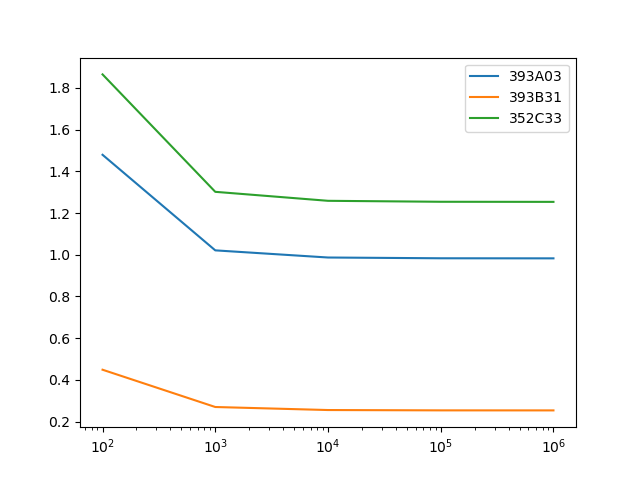

In [184]:
plt.figure()
N = acqui.num_timesteps
dt_facs= [0.001,0.01,0.1,1,10,100,1000]
Ns = [100,1000,10000,100000,1000000]

for sensor in ['393A03','393B31','352C33']:
    ratios = []
    dt_fac=1
    for N in Ns:
        dt = acqui.deltat*dt_fac
        dt=1/2000
        # sensor = '393A03'
        # sensor = '393B31'
        # sensor = '352C33'
        spectral_freq = np.array([1,10,100,1000])/dt_fac
        spectral_noise_table = {
            '393A03': [20e-6, 4e-6, 2e-6, 1e-6],
            '393B31': [0.6e-6, 0.1e-6, 0.04e-6, 0],
            '352C33': [380e-6, 110e-6, 33e-6, 14e-6]
            }
        broadband_res = {"393A03": 0.0001, "393B31":  0.000009, "352C33": 0.0015}[sensor]

        freq = np.fft.rfftfreq(N, dt)
        
        delta_f = freq[1]-freq[0]
        phase = np.random.uniform (-np.pi, np.pi, N//2+1)
        # Amplitude/RMS spectral density given, must not be square rooted for IFFT
        psd = np.interp(freq, spectral_freq, spectral_noise_table[sensor]) * np.exp(1j * phase)
        # Convert spectral density [(µm/sec2)/√Hz] to spectrum [(µm/sec2)/Hz]
        psd /= np.sqrt(dt)
        # Apply ortho norm here, because we input an unnormalized amplitude spectrum (normally PSD * N and norm backward applies 1/N)
        spectral_noise = np.fft.irfft(psd, norm='ortho')        
        # Normalization to DC component (?)
        spectral_noise *= 2*np.pi
        
        RMS_noise = np.sqrt(np.average(spectral_noise**2))
        integr_noise = np.sqrt(np.sum(np.abs(psd)**2)/N*2) # delta_f=1/dt/N: integration, 2: one-sided
        ratios.append(integr_noise/broadband_res)
        display(f'Noise floor RMS generated: {RMS_noise:1.3e} and specified: { broadband_res:1.3e} and integrated: {integr_noise:1.3e}, ratio: {RMS_noise/broadband_res}, {integr_noise/broadband_res},  {RMS_noise/integr_noise}')
    # plt.plot(dt_facs, ratios)
    plt.plot(Ns, ratios, label=sensor)
    # plt.yscale('log')
    plt.xscale('log')
plt.legend()

In [185]:
display(f'Signal energy in time domain: {np.sum(spectral_noise**2):1.3e}, in frequency domain {2*np.sum(np.abs(psd)**2)/N:1.3e}')
delta_f = freq[1]-freq[0]
display(f'Noise floor RMS generated: {RMS_noise:1.3e} and specified: { broadband_res:1.3e} and integrated: {np.sum(np.abs(psd)*delta_f):1.3e}, ratio: {RMS_noise/broadband_res}')

'Signal energy in time domain: 1.396e+02, in frequency domain 3.536e-06'

'Noise floor RMS generated: 1.181e-02 and specified: 1.500e-03 and integrated: 1.349e+00, ratio: 7.876569900393864'

In [211]:
N=1000
signal = np.random.normal(0,0.000004,N)
spec = np.fft.fft(signal)
np.sqrt(np.mean(np.abs(spec)**2)), np.sqrt(np.sum(signal**2)), np.std(signal), np.sqrt(np.mean(signal**2))
# plt.figure()
# plt.plot(np.abs(spec)**2)

(0.00012097399977702707,
 0.00012097399977702707,
 3.825211356426054e-06,
 3.825533769561072e-06)

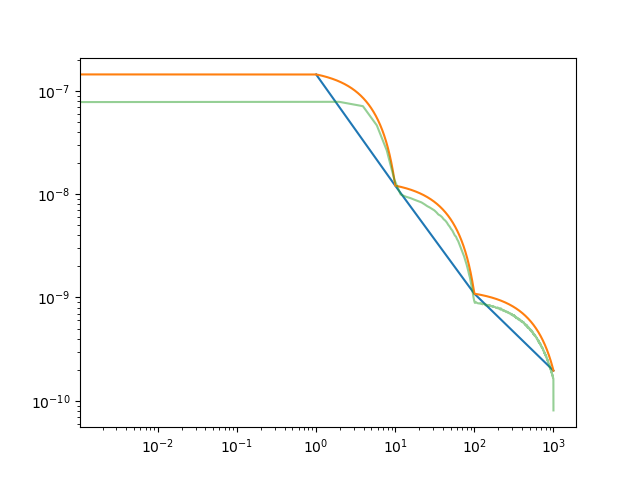

In [137]:
plt.figure()
# data sheed noise spectral density
plt.plot(spectral_freq, (np.array(spectral_noise_table[sensor]))**2)

# interpolated noise spectral density
plt.plot(freq, (np.abs(psd)*np.sqrt(dt))**2)

# synthesized-noise spectral density
f,spec = scipy.signal.csd(spectral_noise, spectral_noise, 1/dt, nperseg=1024, scaling='spectrum')
# apply ortho norm and normalize by 2pi
spec*=np.sqrt(dt)
spec/=2*np.pi
plt.plot(f, spec, alpha=0.5)
plt.xscale('log')
plt.yscale('log')

Text(0, 0.5, 'Acceleration [ms^-2]')

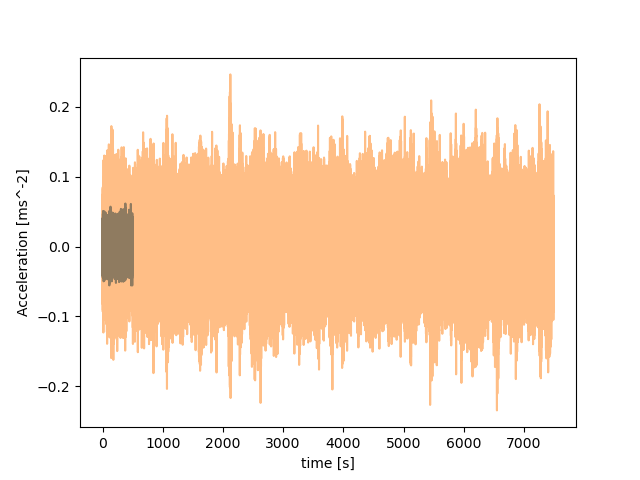

In [141]:
plt.figure()
plt.plot(np.linspace(0, N*dt,N), spectral_noise)
plt.plot(acqui.t_vals, acqui.signal[0,:], alpha=0.5)
plt.xlabel('time [s]')
plt.ylabel('Acceleration [ms^-2]')

/tmp/ipykernel_16980/766504611.py:27: RuntimeWarning: divide by zero encountered in log10
  asd = np.power(10.0, np.interp(np.log10(freq), np.log10(spectral_freq), np.log10(noise_profile))) * np.exp(1j * phase)


'Noise Energy: Broadband 2.839e-03, Spectral: 1.449e-03, Ratio: 1.960'

'Noise Energy: Broadband 6.520e-03, Spectral: 5.933e-04, Ratio: 10.990'

'Noise Energy: Broadband 3.555e-03, Spectral: 5.307e-04, Ratio: 6.699'

'Noise Energy: Broadband 3.558e-03, Spectral: 4.404e-04, Ratio: 8.080'

'Noise Energy: Broadband nan, Spectral: 1.188e-01, Ratio: nan'

'Noise Energy: Broadband 1.772e-02, Spectral: 1.160e-02, Ratio: 1.528'

'Noise Energy: Broadband 1.065e-02, Spectral: 3.026e-03, Ratio: 3.519'

'Noise Energy: Broadband 2.126e-02, Spectral: 5.789e-03, Ratio: 3.672'

'Noise Energy: Broadband 2.174e-02, Spectral: 5.281e-03, Ratio: 4.116'

'Noise Energy: Broadband 2.898e-02, Spectral: 7.427e-03, Ratio: 3.902'

'Noise Energy: Broadband 1.306e-02, Spectral: 1.186e-03, Ratio: 11.007'

'Noise Energy: Broadband 1.418e-02, Spectral: 4.221e-03, Ratio: 3.360'

'Noise Energy: Broadband nan, Spectral: 1.188e-01, Ratio: nan'

'Noise Energy: Broadband 1.137e-01, Spectral: 7.021e-02, Ratio: 1.619'

'Noise Energy: Broadband 2.839e-01, Spectral: 1.781e-01, Ratio: 1.594'

'Noise Energy: Broadband 9.926e-02, Spectral: 5.645e-02, Ratio: 1.758'

'Noise Energy: Broadband 1.847e-01, Spectral: 8.002e-02, Ratio: 2.308'

'Noise Energy: Broadband 7.222e-02, Spectral: 2.155e-02, Ratio: 3.352'

'Noise Energy: Broadband 5.789e-02, Spectral: 1.584e-02, Ratio: 3.656'

'Noise Energy: Broadband nan, Spectral: 1.189e-01, Ratio: nan'

'Noise Energy: Broadband 2.483e+00, Spectral: 3.981e-01, Ratio: 6.238'

'Noise Energy: Broadband 1.065e+00, Spectral: 2.137e-01, Ratio: 4.981'

'Noise Energy: Broadband 5.694e-01, Spectral: 2.137e-01, Ratio: 2.664'

'Noise Energy: Broadband 2.130e+00, Spectral: 4.733e-01, Ratio: 4.500'

'Noise Energy: Broadband 2.125e+00, Spectral: 4.733e-01, Ratio: 4.490'

'Noise Energy: Broadband 3.558e+00, Spectral: 7.205e-02, Ratio: 49.377'

'Noise Energy: Broadband nan, Spectral: 1.188e-01, Ratio: nan'

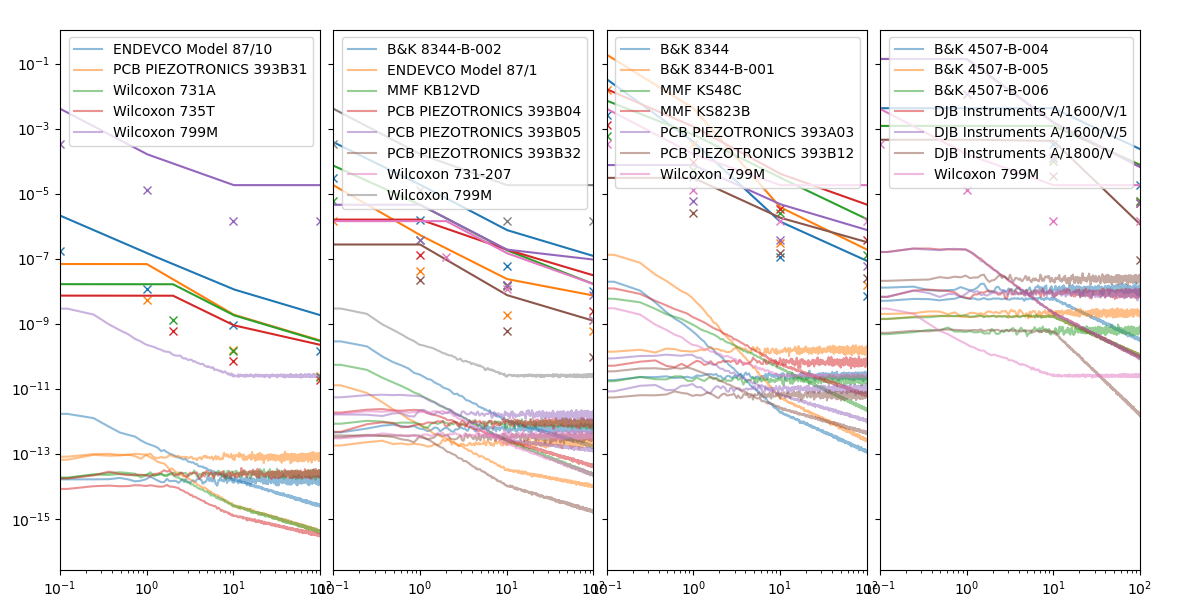

In [240]:
N = acqui.num_timesteps
dt = acqui.deltat
dt = 1/2000
sensitivity=1000
fig, axes = plt.subplots(1,4,sharex=True, sharey=True, figsize=(1200/100,600/100))
# for ax, (sensi_l, sensi_h) in zip(axes,[(0,110),(200,520), (1000,1030)]):
for ax, (noise_l, noise_h) in zip(axes, [(0,1e-5), (1e-5,5e-5), (5e-5,5e-4), (5e-4,5e-3)]):
    # plt.figure()
     # sensi_l, sensi_h = sensitivity*0.9, sensitivity*1.1
    plt.sca(ax)
    for sensor, row in sensor_data.iterrows():
        broadband_noise = row['Broadband Resolution / Noise Floor / Residual Noise / Threshold'].item()
        # if row['Sensitivity'].item() > sensi_h: continue
        # if row['Sensitivity'].item() < sensi_l: continue
        if broadband_noise > noise_h: continue
        if broadband_noise < noise_l: continue
        noise_profile = row[19:26].array.astype(float)*1e-6
        if np.all(np.isnan(noise_profile)): continue
        spectral_freq = np.array([0.1,1,2,10,100,1000,10000])[~np.isnan(noise_profile)]
        noise_profile = noise_profile[~np.isnan(noise_profile)]

        freq = np.fft.rfftfreq(N, dt)

        delta_f = freq[1]-freq[0]
        phase = np.random.uniform (-np.pi, np.pi, N//2+1)
        # Interpolate in log-log-space
        asd = np.power(10.0, np.interp(np.log10(freq), np.log10(spectral_freq), np.log10(noise_profile))) * np.exp(1j * phase)
        # Amplitude/RMS spectrum given, must not be square rooted for IFFT
        # Convert spectral density [(µm/sec2)/√Hz] to unnormalized FFT [(µm/sec2)]
        # https://physics.stackexchange.com/questions/615349/amplitude-spectral-density-vs-power-spectral-density
        # why sqrt(N) ? and not N or 1 / N? its the equivalent of ortho norm in irfft, but why would it be given in that form?
        fft = asd * np.sqrt(N) / np.sqrt(delta_f)
        # Transform to time-domain
        spectral_noise = np.fft.irfft(fft)
        # Broadband noise is given as RMS noise == standard deviation of normal distribution
        broadband_noise = np.random.normal(0, broadband_noise, N)
        
        # With these routines, noise energies match approximately 
        # of course broadband noise is measured over a wider frequency range
        P_bb_noise = np.sqrt(np.sum(broadband_noise**2))
        P_sp_noise = np.sqrt(np.sum(spectral_noise**2))
        display(f'Noise Energy: Broadband {P_bb_noise:1.3e}, Spectral: {P_sp_noise:1.3e}, Ratio: {P_bb_noise/P_sp_noise:1.3f}')
        
        
        
        # plot the Power Spectral Densities (µm/sec2)/Hz
        L2D=plt.plot(*scipy.signal.csd(spectral_noise, spectral_noise, 1/dt, nperseg=2**14, scaling='density'), alpha=0.5, label=row['Manufacturer'].item()+' '+row['Model'].item())
        plt.plot(*scipy.signal.csd(broadband_noise, broadband_noise, 1/dt, nperseg=2**14, scaling='density'), alpha=0.5, color=L2D[0].get_color())
        
        # How to compute the PSD from the ASD / FFT ?
        plt.plot(freq, (np.abs(fft)/N)**2, color=L2D[0].get_color())
        plt.plot(spectral_freq, np.abs(noise_profile/np.sqrt(dt/N)*delta_f)**2, color=L2D[0].get_color(), ls='none', marker='x')
        
    plt.yscale('log')
    plt.xscale('log')
    plt.subplots_adjust(0.05,0.05,0.95,0.95,0.05,0.05)
    plt.xlim((0.1,100))
    plt.legend(loc='upper right')

(0.1, 100)

In [50]:
2**14

16384

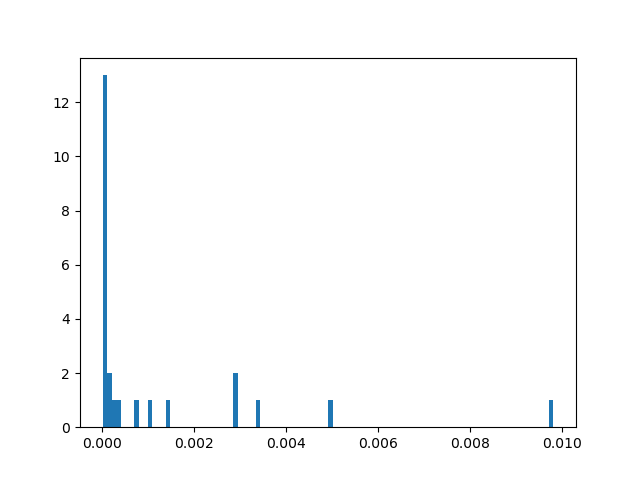

In [46]:
plt.figure()
plt.hist(sensor_data['Broadband Resolution / Noise Floor / Residual Noise / Threshold'], bins=100)
None

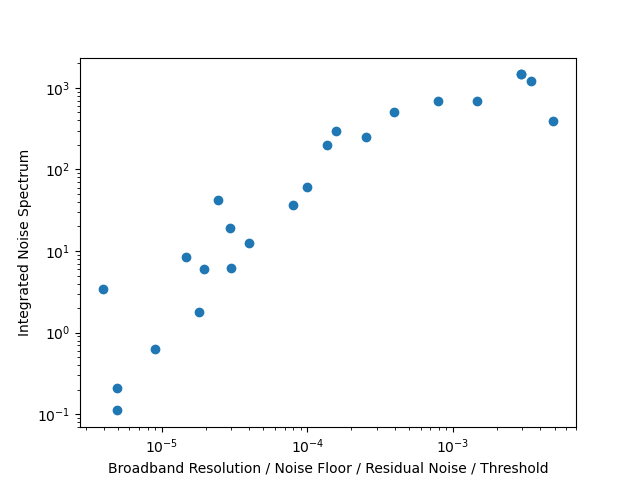

In [140]:
plt.figure()
plt.scatter('Broadband Resolution / Noise Floor / Residual Noise / Threshold', 'Total Noise', data=sensor_data, )
plt.xlabel('Broadband Resolution / Noise Floor / Residual Noise / Threshold')
plt.ylabel('Integrated Noise Spectrum')
plt.xscale("log")
plt.yscale("log")

In [ ]:
'''
cls(t_vals, signal, channel_defs, jobname)

self.num_modes = None
self.snr = [np.mean(signal**2, axis=1), np.zeros((self.num_channels,))]
self.is_sampled = False

Sampling

    Changed/Added Variables/Outputs:
    
    self.modal_frequencies
    self.re_shape[-1]
    self.num_timesteps
    self.deltat
    self.t_vals
    self.signal
    # self.snr
    self.   quantization noise power
    self.   aliasing noise power
    
    Inputs
    
    fs, numtaps, cutoff -> from sample_helper
        f_max -> epistemic
        nyq_rat -> epistemic
        numtaps_fact -> deterministic
    bits, -> epistemic
    meas_range -> from estimate_meas_range
        sample_dur -> epistemic
        margin -> epistemic
        seed -> deterministic
    duration -> epistemic
    
    
Noising

    self.   noise power
    self.signal
    self.snr
    
    snr_db


'''

### Apply sensor

/tmp/ipykernel_16980/4121163826.py:23: RuntimeWarning: divide by zero encountered in log10
  psd = np.power(10.0, np.interp(np.log10(freq), np.log10(spectral_freq), np.log10(noise_profile)))


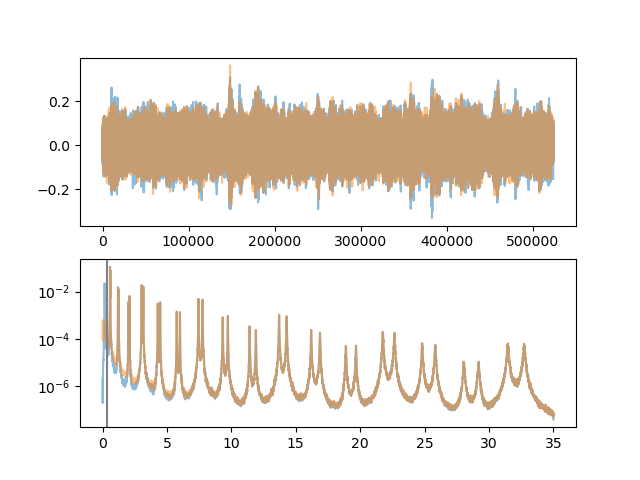

In [137]:
from scipy import signal
DTC = 0.5
spectral_freq = np.array([0.1,1,2,10,100,1000,10000])[[True, True, False, True,True, False, False]]
noise_profile = np.array([420, 46, 2.7, 0.67]) # μm sec^2/√Hz
sensitivity = 9 # mV/m/sec^2
seed = 12345

f_c = 1 / (2 * np.pi * DTC) 
nyq = 1 / acqui.deltat / 2

b, a = signal.butter(4, f_c / nyq, 'high')
meas_sig = signal.lfilter(b, a, acqui.signal, axis=1)
# no need to convert to voltage by sensitivity
# for taking sensitivity deviations into account, 
# we might just apply a scaling factor to acceleration signals

freq = np.fft.rfftfreq(acqui.num_timesteps, acqui.deltat)

delta_f = freq[1]-freq[0]

rng = np.random.default_rng(seed)
phase = rng.uniform(-np.pi, np.pi, (acqui.num_channels, acqui.num_timesteps // 2 + 1))
psd = np.power(10.0, np.interp(np.log10(freq), np.log10(spectral_freq), np.log10(noise_profile)))
for channel in range(acqui.num_channels):
    spectral_noise = np.fft.irfft(psd * np.exp(1j * phase[channel,:]) / np.sqrt(acqui.deltat), norm='ortho') * (2 * np.pi)**2
    meas_sig[channel, :] += spectral_noise * 1e-6


fig, (ax1,ax2) = plt.subplots(2,1)


channel = 10

ax1.plot(acqui.signal[channel,:], alpha=0.5)
ax1.plot(meas_sig[channel,:], alpha=0.5)
ax2.plot(*scipy.signal.csd(acqui.signal[channel,:], acqui.signal[channel,:], 1/ acqui.deltat, nperseg=2**14, scaling='density'), alpha=0.5, )
ax2.plot(*scipy.signal.csd(meas_sig[channel,:], meas_sig[channel,:], 1/ acqui.deltat, nperseg=2**14, scaling='density'), alpha=0.5, )
# ax2.plot(freq, np.abs(np.fft.rfft(acqui.signal[channel,:])), alpha=0.5)
ax2.set_yscale('log')
# ax2.plot(freq, np.abs(np.fft.rfft(meas_sig[channel,:])), alpha=0.5)
# ax4.set_yscale('log')
ax2.axvline(f_c, color='grey')
# ax4.axvline(f_c, color='grey')
# ax4.set_xlim((0,f_c*3))

In [ ]:
'''
continue
- get PSD plots and noise profiles to match in spectral noise cells
- big suplots with all channels, similar to PreProcessSignals
- make it a function and call it for each sensor, generate plots
- think about uncertain variables again
- implement it into class Acquire
- ...
'''